In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("src/network.jl")
include("src/vsa.jl")
include("src/spiking.jl")

zero_nans (generic function with 1 method)

In [4]:
model = Chain(PhasorDense(128 => 128), )

Chain(
  PhasorDense(128 => 128),              # 16_512 parameters
) 

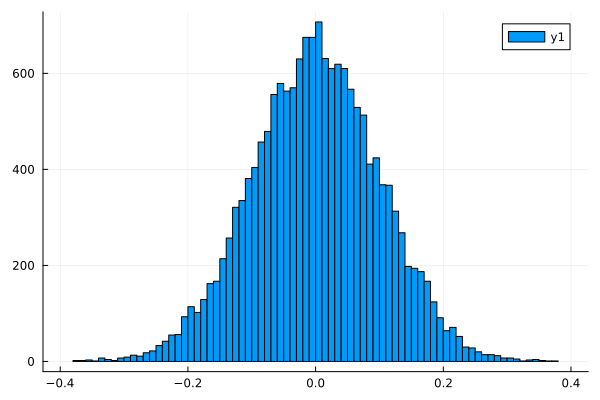

In [5]:
histogram(model[1].weight |> vec)

In [8]:
x = random_symbols((100, 128));

In [9]:
x |> size

(100, 128)

In [10]:
model2 = Chain(PhasorDense(model[1].weight, zero(model[1].bias)))

Chain(
  PhasorDense(128 => 128),              # 16_512 parameters
) 

In [11]:
y = model(x);

In [12]:
y2 = model2(x);

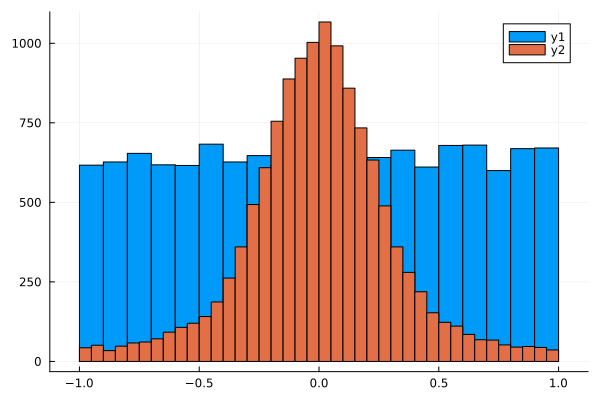

In [13]:
histogram(y2 |> vec)
histogram!(y |> vec)

In [14]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [15]:
sa = SpikingArgs(2*pi, -0.2, 1.0, 0.03, 0.02, 0.005)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [16]:
xt = phase_to_train(x, sa, repeats = 10)

Spike Train: (100, 128) with 128000 spikes.

In [17]:
call = SpikingCall(xt, sa, (0.0, 20.0))

SpikingCall(Spike Train: (100, 128) with 128000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 20.0))

In [18]:
y_sol = model2[1](call, return_solution=true)

retcode: Success
Interpolation: 3rd order Hermite
t: 4001-element Vector{Float64}:
  0.0
  0.005
  0.01
  0.015
  0.02
  0.025
  0.030000000000000002
  0.035
  0.04
  0.045
  0.049999999999999996
  0.05499999999999999
  0.05999999999999999
  ⋮
 19.945000000000316
 19.950000000000315
 19.955000000000314
 19.960000000000313
 19.965000000000312
 19.97000000000031
 19.97500000000031
 19.98000000000031
 19.98500000000031
 19.990000000000308
 19.995000000000307
 20.0
u: 4001-element Vector{Matrix{ComplexF32}}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [-0.002164228f0 - 3.313651f-5im -0.0009097548f0 - 1.1748813f-5im … -0.00022407305f0 - 8.7955f-6im -0.002362351f0 - 4.4136745f-5im; 0.00044301405f0 + 6.9623297f-6im -7.34191f-5 - 1.1538415f-6im … 0.001219185f0 + 1.91

In [19]:
y_spikes = find_spikes_rf(y_sol, call.spk_args)

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128), CartesianIndex(100, 128)], [0.7200000000000005, 1.6999999999999857, 2.689999999999965, 3.6849999999999437, 4.684999999999922, 5.679999999999901, 6.67999999999988, 7.6799999999998585, 8.679999999999957, 9.680000000000113  …  10.420000000000229, 11.420000000000385, 12.420000000000542, 13.420000000000698, 14.420000000000854, 15.42000000000101, 16.420000000001018, 17.42000000000082, 18.42000000000062, 19.42000000000042])

In [20]:
y_call = SpikingCall(SpikeTrain(y_spikes[1], y_spikes[2], size(y_sol.u[1]), 0.25), sa, (0.0, 20.0))

SpikingCall(Spike Train: (100, 128) with 244649 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 20.0))

In [21]:
y_sol.u[1] |> size

(100, 128)

In [22]:
function get_us(sol, idx)
    return mapreduce(x->getindex(x, idx), vcat, sol.u);
end

get_us (generic function with 1 method)

In [23]:
function get_tms_us(x, sol, u, index)
    inds = map(x-> x == index, x[1])
    tms = x[2][inds]
    u_inds = findall(vec(sum(sol.t .== tms', dims=2) .> 0))
    us = u[u_inds]
    return (tms, us)
end

get_tms_us (generic function with 1 method)

In [24]:
function generate_plot(sol, spikes, idx)
    u = get_us(sol, idx)
    tms, peaks = get_tms_us(spikes, sol, u, idx)

    fig = plot(sol.t, real.(u))
    plot!(sol.t, imag.(u))
    scatter!(tms, imag.(peaks))
    return fig
end

generate_plot (generic function with 1 method)

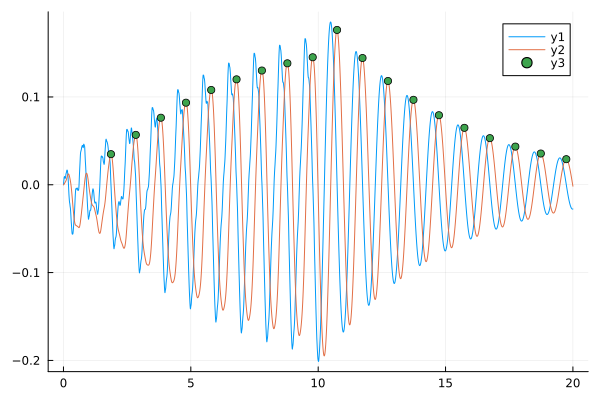

In [25]:
generate_plot(y_sol, y_spikes, CartesianIndex(100,1))

In [26]:
n1_u = get_us(y_sol, CartesianIndex(1,1))
n1_tms, n1_peaks = get_tms_us(y_spikes, y_sol, n1_u, CartesianIndex(1,1))

([0.7200000000000005, 1.6999999999999857, 2.689999999999965, 3.6849999999999437, 4.684999999999922, 5.679999999999901, 6.67999999999988, 7.6799999999998585, 8.679999999999957, 9.680000000000113, 10.660000000000267, 11.660000000000423, 12.66000000000058, 13.660000000000736, 14.660000000000892, 15.660000000001048, 16.66000000000097, 17.66000000000077, 18.660000000000572, 19.660000000000373], ComplexF32[0.0021360563f0 + 0.040008646f0im, 0.004155074f0 + 0.09994535f0im, 0.006019625f0 + 0.15028314f0im, 0.007211052f0 + 0.19187921f0im, 0.0028668381f0 + 0.22604308f0im, 0.009294543f0 + 0.25413248f0im, 0.007054036f0 + 0.27712837f0im, 0.005200278f0 + 0.29595256f0im, 0.0036667255f0 + 0.3113617f0im, 0.002398289f0 + 0.3239754f0im, 0.005178792f0 + 0.2931622f0im, 0.0039917105f0 + 0.24000746f0im, 0.003064845f0 + 0.19649017f0im, 0.0023428958f0 + 0.16086319f0im, 0.001781976f0 + 0.13169572f0im, 0.0013474536f0 + 0.1078168f0im, 0.0010119249f0 + 0.08826745f0im, 0.00075377186f0 + 0.07226272f0im, 0.00055595435f

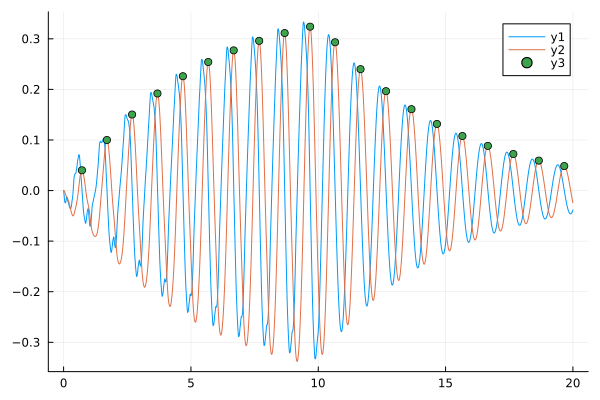

In [27]:
plot(y_sol.t, real.(n1_u))
plot!(y_sol.t, imag.(n1_u))
scatter!(n1_tms, imag.(n1_peaks))

In [28]:
CartesianIndex(1,1)

CartesianIndex(1, 1)

In [29]:
n2_u = mapreduce(x->getindex(x, CartesianIndex(1,2)), vcat, y_sol.u);

In [30]:
n2_tms, n2_peaks = get_tms_us(y_spikes, y_sol, n2_u, CartesianIndex(1,2))

([1.6599999999999866, 2.6699999999999653, 3.674999999999944, 4.6799999999999224, 5.679999999999901, 6.67999999999988, 7.6799999999998585, 8.679999999999957, 9.680000000000113, 10.68500000000027, 11.685000000000427, 12.685000000000583, 13.68500000000074, 14.685000000000896, 15.685000000001052, 16.685000000000965, 17.685000000000766, 18.685000000000567, 19.685000000000368], ComplexF32[0.0024837565f0 + 0.047459472f0im, 0.0021372265f0 + 0.08468084f0im, 0.0019002263f0 + 0.11524489f0im, 0.00010979263f0 + 0.14025253f0im, 0.0013350127f0 + 0.16081837f0im, 0.0023206198f0 + 0.17765616f0im, 0.0031132686f0 + 0.19144152f0im, 0.0037505298f0 + 0.20272791f0im, 0.0042627463f0 + 0.21196824f0im, 0.0047547296f0 + 0.213468f0im, 0.003712014f0 + 0.17476375f0im, 0.002891105f0 + 0.14307687f0im, 0.0022458467f0 + 0.117135145f0im, 0.0017395396f0 + 0.095896855f0im, 0.0013429852f0 + 0.07850934f0im, 0.0010330547f0 + 0.06427432f0im, 0.00079137663f0 + 0.05262031f0im, 0.0006033624f0 + 0.043079283f0im, 0.00045751716f0 + 

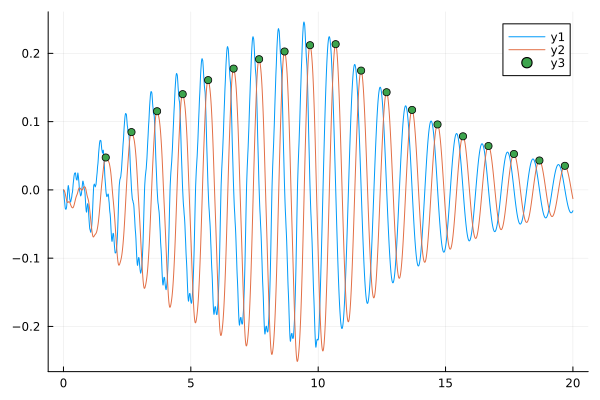

In [31]:
plot(y_sol.t, real.(n2_u))
plot!(y_sol.t, imag.(n2_u))
scatter!(n2_tms, imag.(n2_peaks))

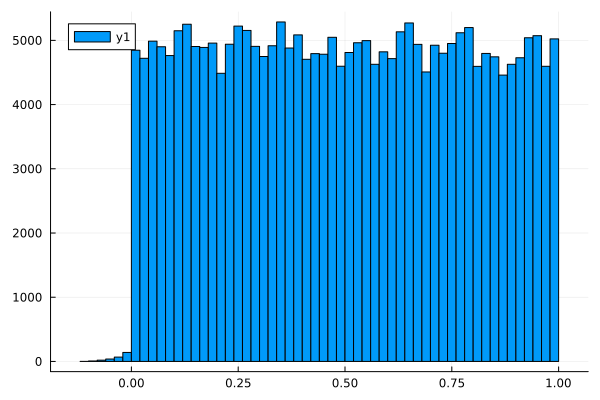

In [32]:
histogram((y_call.train.times .- y_call.train.offset) .% 1.0)


In [33]:
y_sphase = train_to_phase(y_call)

20×100×128 Array{Float64, 3}:
[:, :, 1] =
 -0.06  NaN     NaN     -0.95  NaN     …  -0.93  NaN     -0.97  NaN
 -0.1   NaN      -0.52  -0.79  NaN        -0.82   -0.18   0.97    0.23
 -0.12  NaN      -0.52  -0.76   -0.89     -0.79   -0.24   0.94    0.18
 -0.13   -0.53   -0.52  -0.75   -0.88     -0.78   -0.26   0.93    0.15
 -0.13   -0.52   -0.51  -0.74   -0.88     -0.78   -0.26   0.92    0.12
 -0.14   -0.52   -0.51  -0.74   -0.87  …  -0.78   -0.27   0.91    0.1
 -0.14   -0.51   -0.51  -0.73   -0.87     -0.77   -0.27   0.91    0.09
 -0.14   -0.51   -0.51  -0.73   -0.87     -0.77   -0.27   0.91    0.08
 -0.14   -0.51   -0.51  -0.73   -0.87     -0.77   -0.27   0.91    0.08
 -0.14   -0.51   -0.51  -0.73   -0.87     -0.77   -0.28   0.91    0.07
 -0.18   -0.44   -0.51  -0.72   -0.84  …  -0.76   -0.29   0.89   -0.02
 -0.18   -0.44   -0.51  -0.72   -0.84     -0.76   -0.29   0.89   -0.02
 -0.18   -0.44   -0.51  -0.72   -0.84     -0.76   -0.29   0.89   -0.02
 -0.18   -0.44   -0.51  -0.72   -0.84  

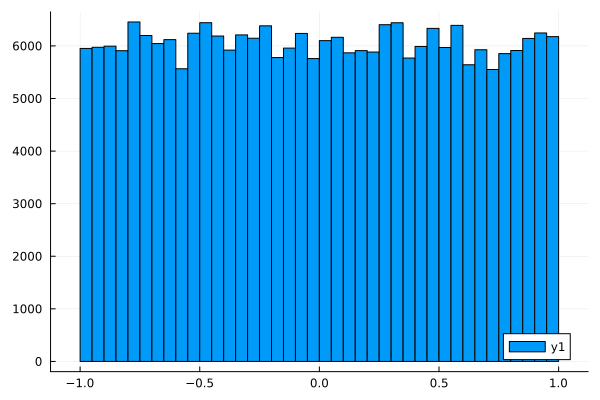

In [34]:
histogram(y_sphase |> vec)

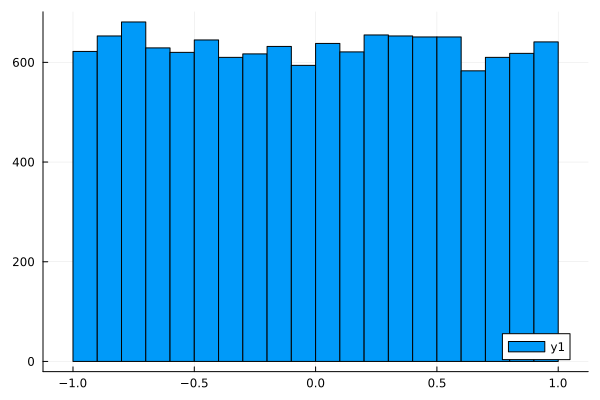

In [35]:
histogram(y_sphase[4,:,:] |> vec, bins=-1.0:0.1:1.0)

In [36]:
cyc4_err = vec(y) .- vec(y_sphase[4,:,:])

12800-element Vector{Float64}:
  0.04604290369314215
  0.4451840838510707
  0.25968271741677795
  0.27717564619513896
  0.6899067336230402
 -0.7753432911835166
 -0.16887971030988957
  0.31674000861694374
 -0.3360463699247337
  0.4898669554757774
  0.43433654918855225
 -0.10185848843404266
  0.0002467246576697141
  ⋮
 -0.19842639138158252
  0.2529178564038765
  0.3680759311531898
  0.37577845502070106
 -0.21073671802507926
 -0.41274028575270855
 -0.03210433634166233
 -0.2108560023008551
 -0.4662652517366458
  0.2710695078022406
  0.3028908329932767
  0.21867228905909697

In [37]:
findall(cyc4_err .> 0.9)

189-element Vector{Int64}:
   328
   343
   348
   381
   430
   490
   553
   608
   690
   696
   721
   824
   847
     ⋮
 11591
 11684
 11705
 11709
 11725
 11968
 12194
 12226
 12244
 12457
 12752
 12757

In [38]:
y_sphase[4,1,16]

-0.8600000000000971

In [39]:
y[16]

0.2973851808353715

In [40]:
y_sphase[16]

-0.17999999999790361

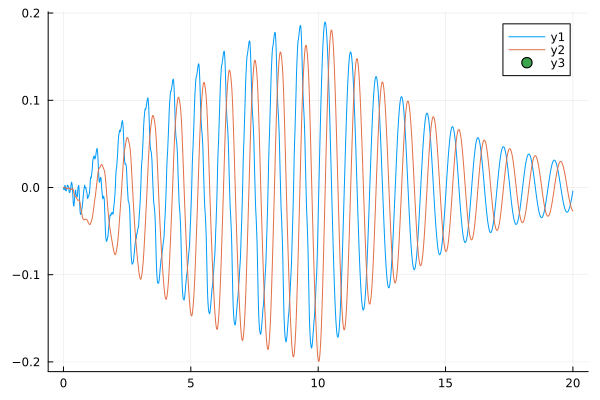

In [41]:
generate_plot(y_sol, y_spikes, 168)

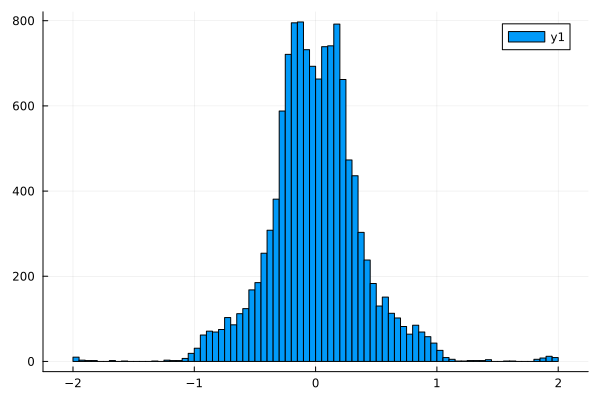

In [42]:
histogram(cyc4_err)

In [43]:
scatter(vec(y), vec(y_sphase[4,:,:]), alpha=0.02)

In [44]:
scatter(vec(y), vec(y_sphase[19,:,:]), alpha=0.03)

In [45]:
n_zeros = mapslices(x->sum(isnan.(x)), y_sphase, dims=(2,3)) |> vec

20-element Vector{Int64}:
 4215
  694
  313
  176
  126
   98
   81
   72
  130
   67
   83
  103
  157
  240
  380
  576
  849
 1197
 1779
 2517

In [46]:
cv = cycle_correlation(y, y_sphase)

20-element Vector{Float64}:
 0.4151523571531188
 0.7396505966832488
 0.7845798888980455
 0.8059533852020292
 0.8186779633643966
 0.8250921528811832
 0.8257696847795274
 0.8257031160921068
 0.8264338121942137
 0.8301175469628487
 0.8295792753396287
 0.8295499442413611
 0.8289684944206639
 0.8319187829169404
 0.8356692519008825
 0.8404318046183135
 0.8448056483256865
 0.8500741578500925
 0.8625651174089426
 0.8735383401724705

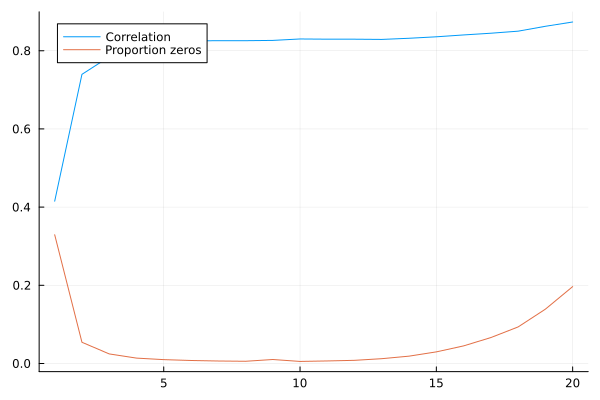

In [47]:
plot(cv, label="Correlation")
plot!(n_zeros / prod(size(y_sphase[1,:,:])), label="Proportion zeros")